# Cargamos los datos

In [22]:
import fastai
import torch
from fastai.vision import *
from shutil import copyfile
import random
import pandas as pd
import numpy as np
plt.rcParams.update({'font.size': 16})





In [23]:
dic = {
      'ATYPICAL_LYMPHOCYTE':[],
      'VARIANT_LYMPHOCYTE':[],
      'BLAST':[]
     }

In [24]:
import os

def print_dirs_recursively(root_dir):
    root_dir = os.path.abspath(root_dir)

    for item in os.listdir(root_dir):
        item_full_path = os.path.join(root_dir, item)
        if os.path.isdir(item_full_path):
            print_dirs_recursively(item_full_path)
        else: 
            if '/ATYPICAL_LYMPHOCYTE/' in item_full_path:
                dic['ATYPICAL_LYMPHOCYTE'].append(item_full_path)
            if '/VARIANT_LYMPHOCYTE/' in item_full_path:
                dic['VARIANT_LYMPHOCYTE'].append(item_full_path)
            if '/BLAST/' in item_full_path:
                dic['BLAST'].append(item_full_path)

print_dirs_recursively('/shared/Clinic')

In [25]:
random.seed(4)
for item in dic.values():
     random.shuffle(item)

In [26]:
def catcher(x): return re.findall('/([a-zA-Z]+)_+[\d]', x)[0]

typ = {
      'ATYPICAL_LYMPHOCYTE':{},
      'VARIANT_LYMPHOCYTE':{},
      'BLAST':{}
     }
for name in dic.keys():
    for path in dic[name]:
        if '.jpg' in path:
            label = catcher(path)
            if label in typ[name]:
                typ[name][label] += 1

            else: 

                typ[name][label] = 1


typ

{'ATYPICAL_LYMPHOCYTE': {'LY': 664,
  'OTH': 2659,
  'VLY': 87,
  'HC': 58,
  'MO': 22,
  'BL': 7,
  'BA': 1,
  'SMU': 1},
 'VARIANT_LYMPHOCYTE': {'LY': 41, 'VLY': 486, 'MO': 24},
 'BLAST': {'BL': 1204, 'LY': 35, 'MO': 1}}

In [27]:
pd.DataFrame.from_dict(typ).replace(np.nan, "")


ATYPICAL_LYMPHOCYTE VARIANT_LYMPHOCYTE BLAST
BA                     1                         
BL                     7                     1204
HC                    58                         
LY                   664                 41    35
MO                    22                 24     1
OTH                 2659                         
SMU                    1                         
VLY                   87                486

In [28]:
folder_1 = os.listdir("/shared/Classification_Clinic_Balanced/train/ATYPICAL_LYMPHOCYTE")
folder_2 = os.listdir("/shared/Classification_Clinic_Balanced/train/VARIANT_LYMPHOCYTE")
folder_3 = os.listdir("/shared/Classification_Clinic_Balanced/train/BLAST")

In [29]:
dic_Classif = {
      'ATYPICAL_LYMPHOCYTE':folder_1,
      'VARIANT_LYMPHOCYTE':folder_2,
      'BLAST':folder_3
     }

def catcher2(x): return re.findall('([a-zA-Z]+)_+[\d]', x)[0]

typ_2 = {
      'ATYPICAL_LYMPHOCYTE':{},
      'VARIANT_LYMPHOCYTE':{},
      'BLAST':{}
     }
for name in dic_Classif.keys():
    for path in dic_Classif[name]:
        if '.jpg' in path:
            label = catcher2(path)
            if label in typ_2[name]:
                typ_2[name][label] += 1

            else: 

                typ_2[name][label] = 1



In [30]:
df_classes = pd.DataFrame.from_dict(typ_2)

In [31]:
pd.DataFrame(df_classes.sum(skipna=True, numeric_only=True)).rename(columns={0:'Total conjunto de datos Train + Test'})



Total conjunto de datos Train + Test
ATYPICAL_LYMPHOCYTE                                1200.0
VARIANT_LYMPHOCYTE                                  449.0
BLAST                                              1000.0

In [32]:
df_classes.replace(np.nan, "")

ATYPICAL_LYMPHOCYTE VARIANT_LYMPHOCYTE BLAST
BL                     1                      974
HC                    22                         
LY                   230                 37    25
MO                     9                 17     1
OTH                  902                         
VLY                   36                395

In [33]:
folder_classes = "/shared/Classification_Clinic_Balanced"
tfms = get_transforms(flip_vert=True, max_warp=None, max_zoom=1.01, max_rotate=120, max_lighting=0.1)

In [34]:
data = (ImageList.from_folder(folder_classes) #Where to find the data? -> in path and its subfolders
        .split_by_rand_pct(seed=4)           #How to split in train/valid? -> use the folders
        .label_from_folder()    
        .transform(tfms, size=224)       #Data augmentation? -> use tfms with a size of 64
        .databunch()
        .normalize(imagenet_stats))   

In [35]:
pd.DataFrame.from_dict({'Número de Clases':[data.c],
'train_size':[len(data.train_ds)],
'valid_size':[len(data.valid_ds)]},                     
orient = 'index', columns=['Conteo del Conjunto de Datos'])

Conteo del Conjunto de Datos
Número de Clases                             3
train_size                                2331
valid_size                                 582

In [36]:
train_ds = data.train_ds.to_df()
pd.DataFrame(train_ds['y'].value_counts()).rename(columns={'y':'Conteo en el conjunto de datos Train'})

Conteo en el conjunto de datos Train
ATYPICAL_LYMPHOCYTE                                  1026
BLAST                                                 866
VARIANT_LYMPHOCYTE                                    439

In [37]:
valid_ds = data.valid_ds.to_df()
pd.DataFrame(valid_ds['y'].value_counts()).rename(columns={'y':'Conteo en el conjunto de datos Validation'})

Conteo en el conjunto de datos Validation
ATYPICAL_LYMPHOCYTE                                        243
BLAST                                                      227
VARIANT_LYMPHOCYTE                                         112

# Descripcion del conjunto de datos

In [38]:
data.batch_size = 20

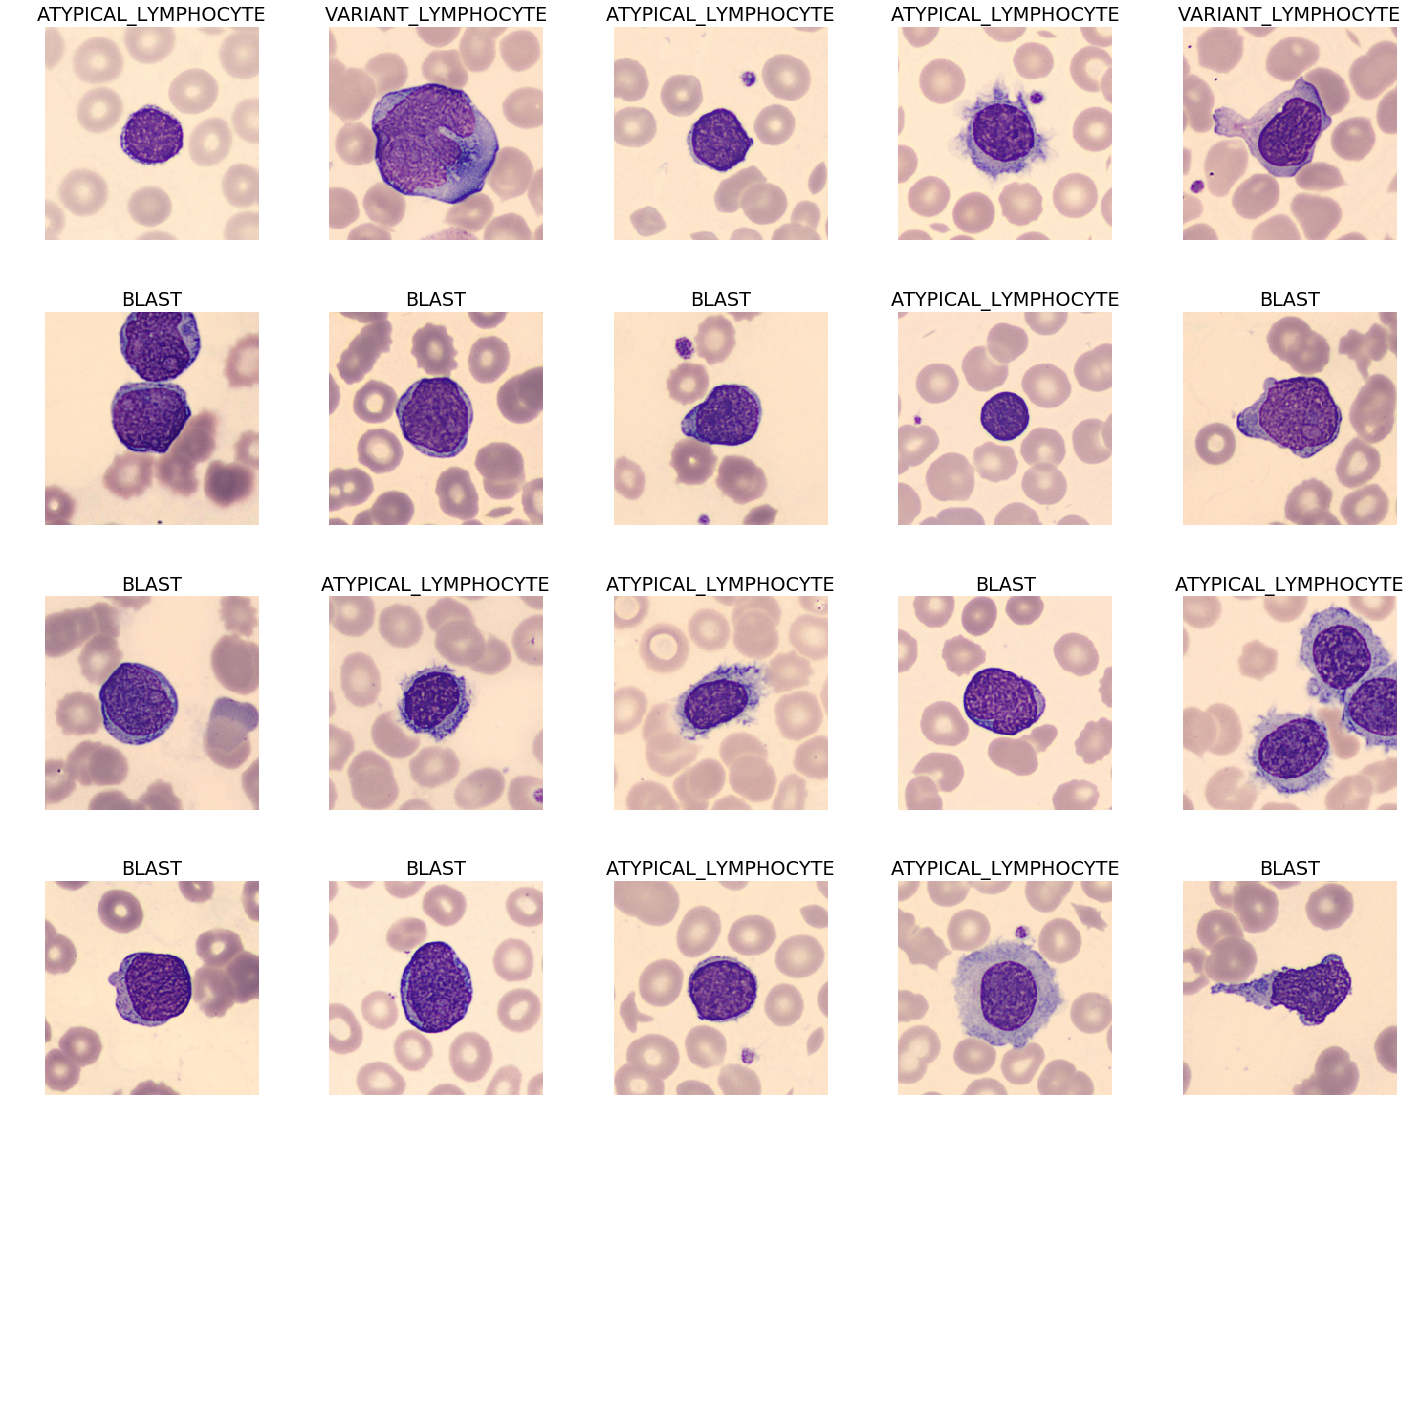

In [39]:
data.show_batch()

In [40]:
learn = None

In [41]:
learn = cnn_learner(data, models.resnet34, metrics=[error_rate, accuracy], pretrained='imagenet')


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


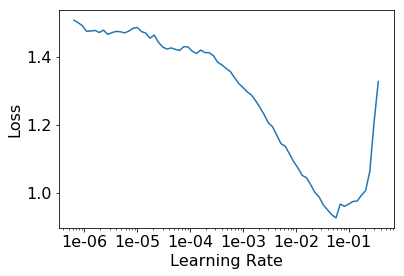

In [42]:
learn.lr_find()
learn.recorder.plot()

In [47]:
gc.collect()

0

In [46]:
learn.fit_one_cycle(8)

In [48]:
learn.export('export_stage-1-34-Clinic_Balanced_3_Classes')

In [49]:
learn.unfreeze()
learn.fit_one_cycle((5), max_lr=slice(1e-3,1e-2))

In [50]:
learn.fit_one_cycle((2), max_lr=slice(1e-4,1e-3))

In [51]:
learn.fit_one_cycle((2), max_lr=slice(1e-4,1e-3))

In [52]:
learn.fit_one_cycle((2), max_lr=slice(1e-4,1e-3))

In [53]:
learn.fit_one_cycle((2), max_lr=slice(1e-5,1e-4))

In [54]:
learn.fit_one_cycle((2), max_lr=slice(1e-5,1e-4))

In [78]:
learn.export('export_stage-2-34-Clinic_Balanced_3_Classes')

In [56]:
interp = ClassificationInterpretation.from_learner(learn)

interp.most_confused(min_val=2)

[('ATYPICAL_LYMPHOCYTE', 'BLAST', 4),
 ('ATYPICAL_LYMPHOCYTE', 'VARIANT_LYMPHOCYTE', 2),
 ('VARIANT_LYMPHOCYTE', 'ATYPICAL_LYMPHOCYTE', 2)]

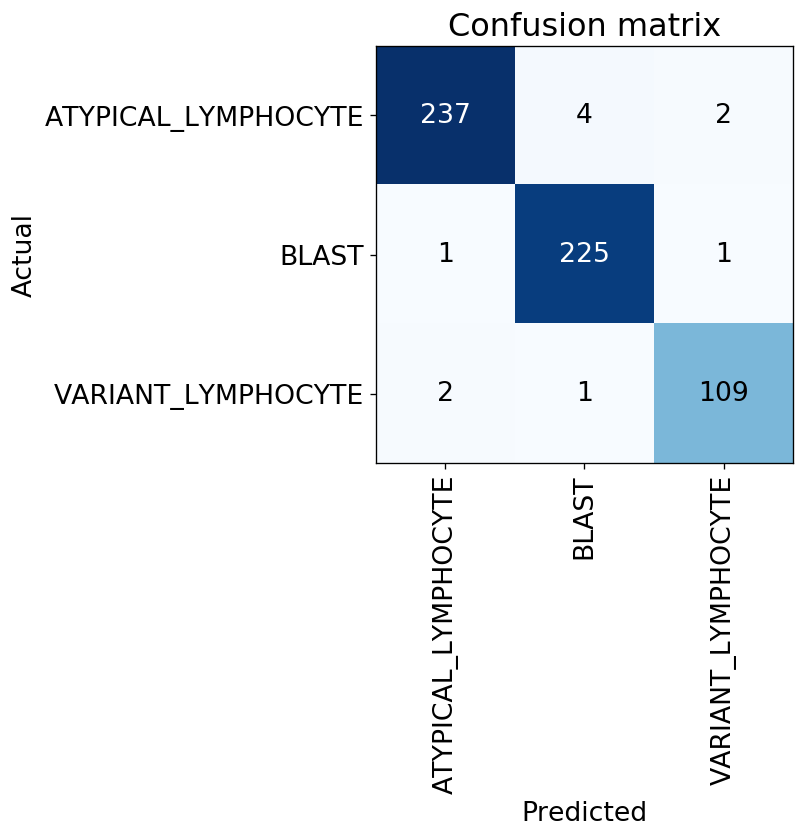

In [63]:
interp.plot_confusion_matrix(figsize=(7,7), dpi=120)

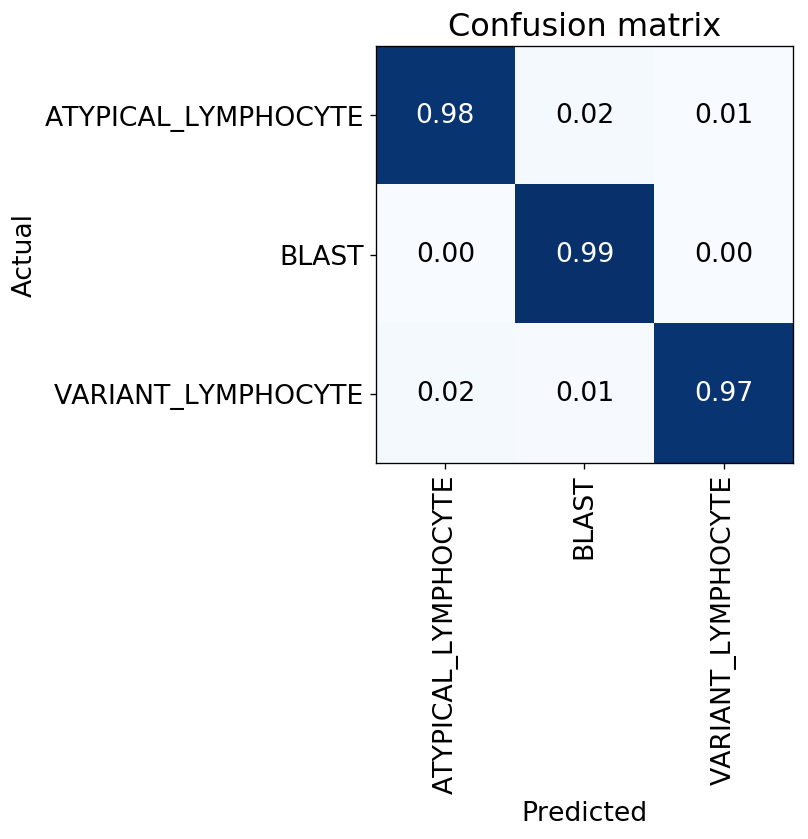

In [62]:
interp.plot_confusion_matrix(figsize=(7,7), dpi=120,normalize = True)

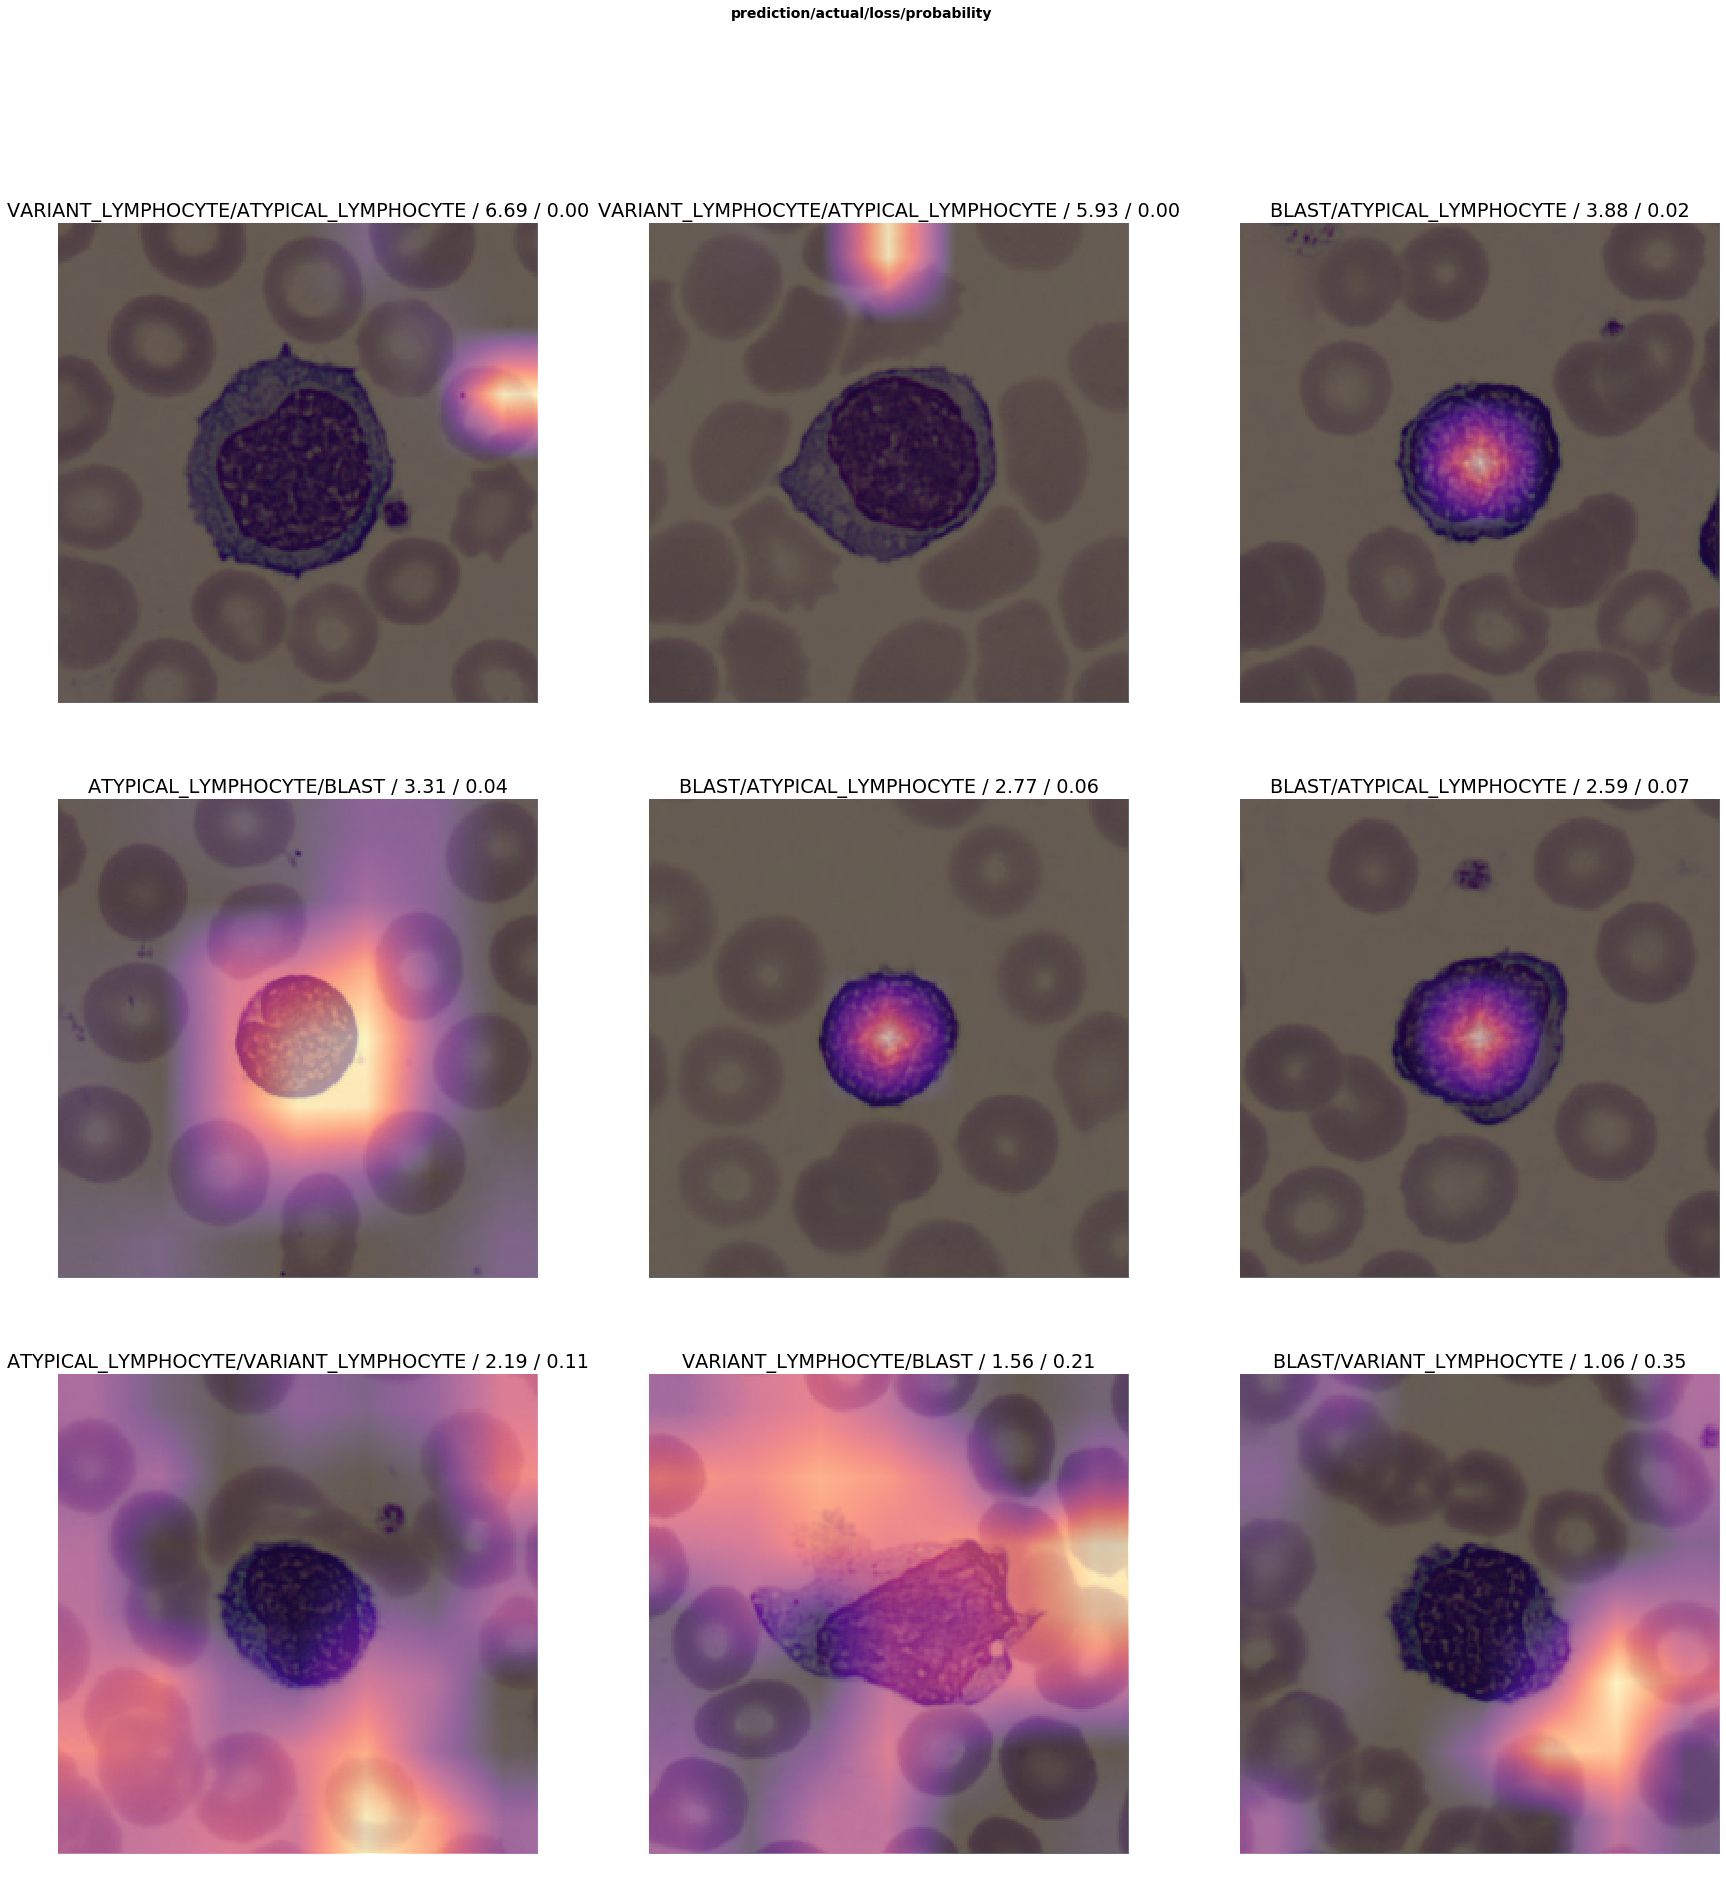

In [64]:
interp.plot_top_losses(9, largest=True, figsize=(30,30), heatmap=True)

Validando el ``test_set``






In [65]:
data_test = (ImageList.from_folder(folder_classes) #Where to find the data? -> in path and its subfolders
        .split_by_folder(train='train', valid='test')       #How to split in train/valid? -> use the folders
        .label_from_folder()    
        .transform(tfms, size=224)       #Data augmentation? -> use tfms with a size of 64
        .databunch()
        .normalize(imagenet_stats))   



In [66]:
data_test

ImageDataBunch;

Train: LabelList (2649 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
BLAST,BLAST,BLAST,BLAST,BLAST
Path: /shared/Classification_Clinic_Balanced;

Valid: LabelList (264 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
BLAST,BLAST,BLAST,BLAST,BLAST
Path: /shared/Classification_Clinic_Balanced;

Test: None

In [67]:
valid_ds = data_test.valid_ds.to_df()
pd.DataFrame(valid_ds['y'].value_counts()).rename(columns={'y':'Conteo de clases en test set'})

Conteo de clases en test set
VARIANT_LYMPHOCYTE                            102
BLAST                                          93
ATYPICAL_LYMPHOCYTE                            69

In [68]:
learn_test = load_learner( '/shared/Classification_Clinic_Balanced', 'export_stage-2-34-Clinic_Balanced_3_Classes') 
learn_test.data = data_test
learn_test.data.batch_size = 20

In [69]:
metrics_valid = learn_test.validate(data_test.valid_dl)

In [70]:
valid_results = dict(zip(['valid_loss', 'error_rate', 'accuracy'],
                         [metrics_valid[0], metrics_valid[1].item(),metrics_valid[2].item()]))
pd.DataFrame(valid_results, index = ['metrics'])

valid_loss  error_rate  accuracy
metrics    0.060087    0.018939  0.981061

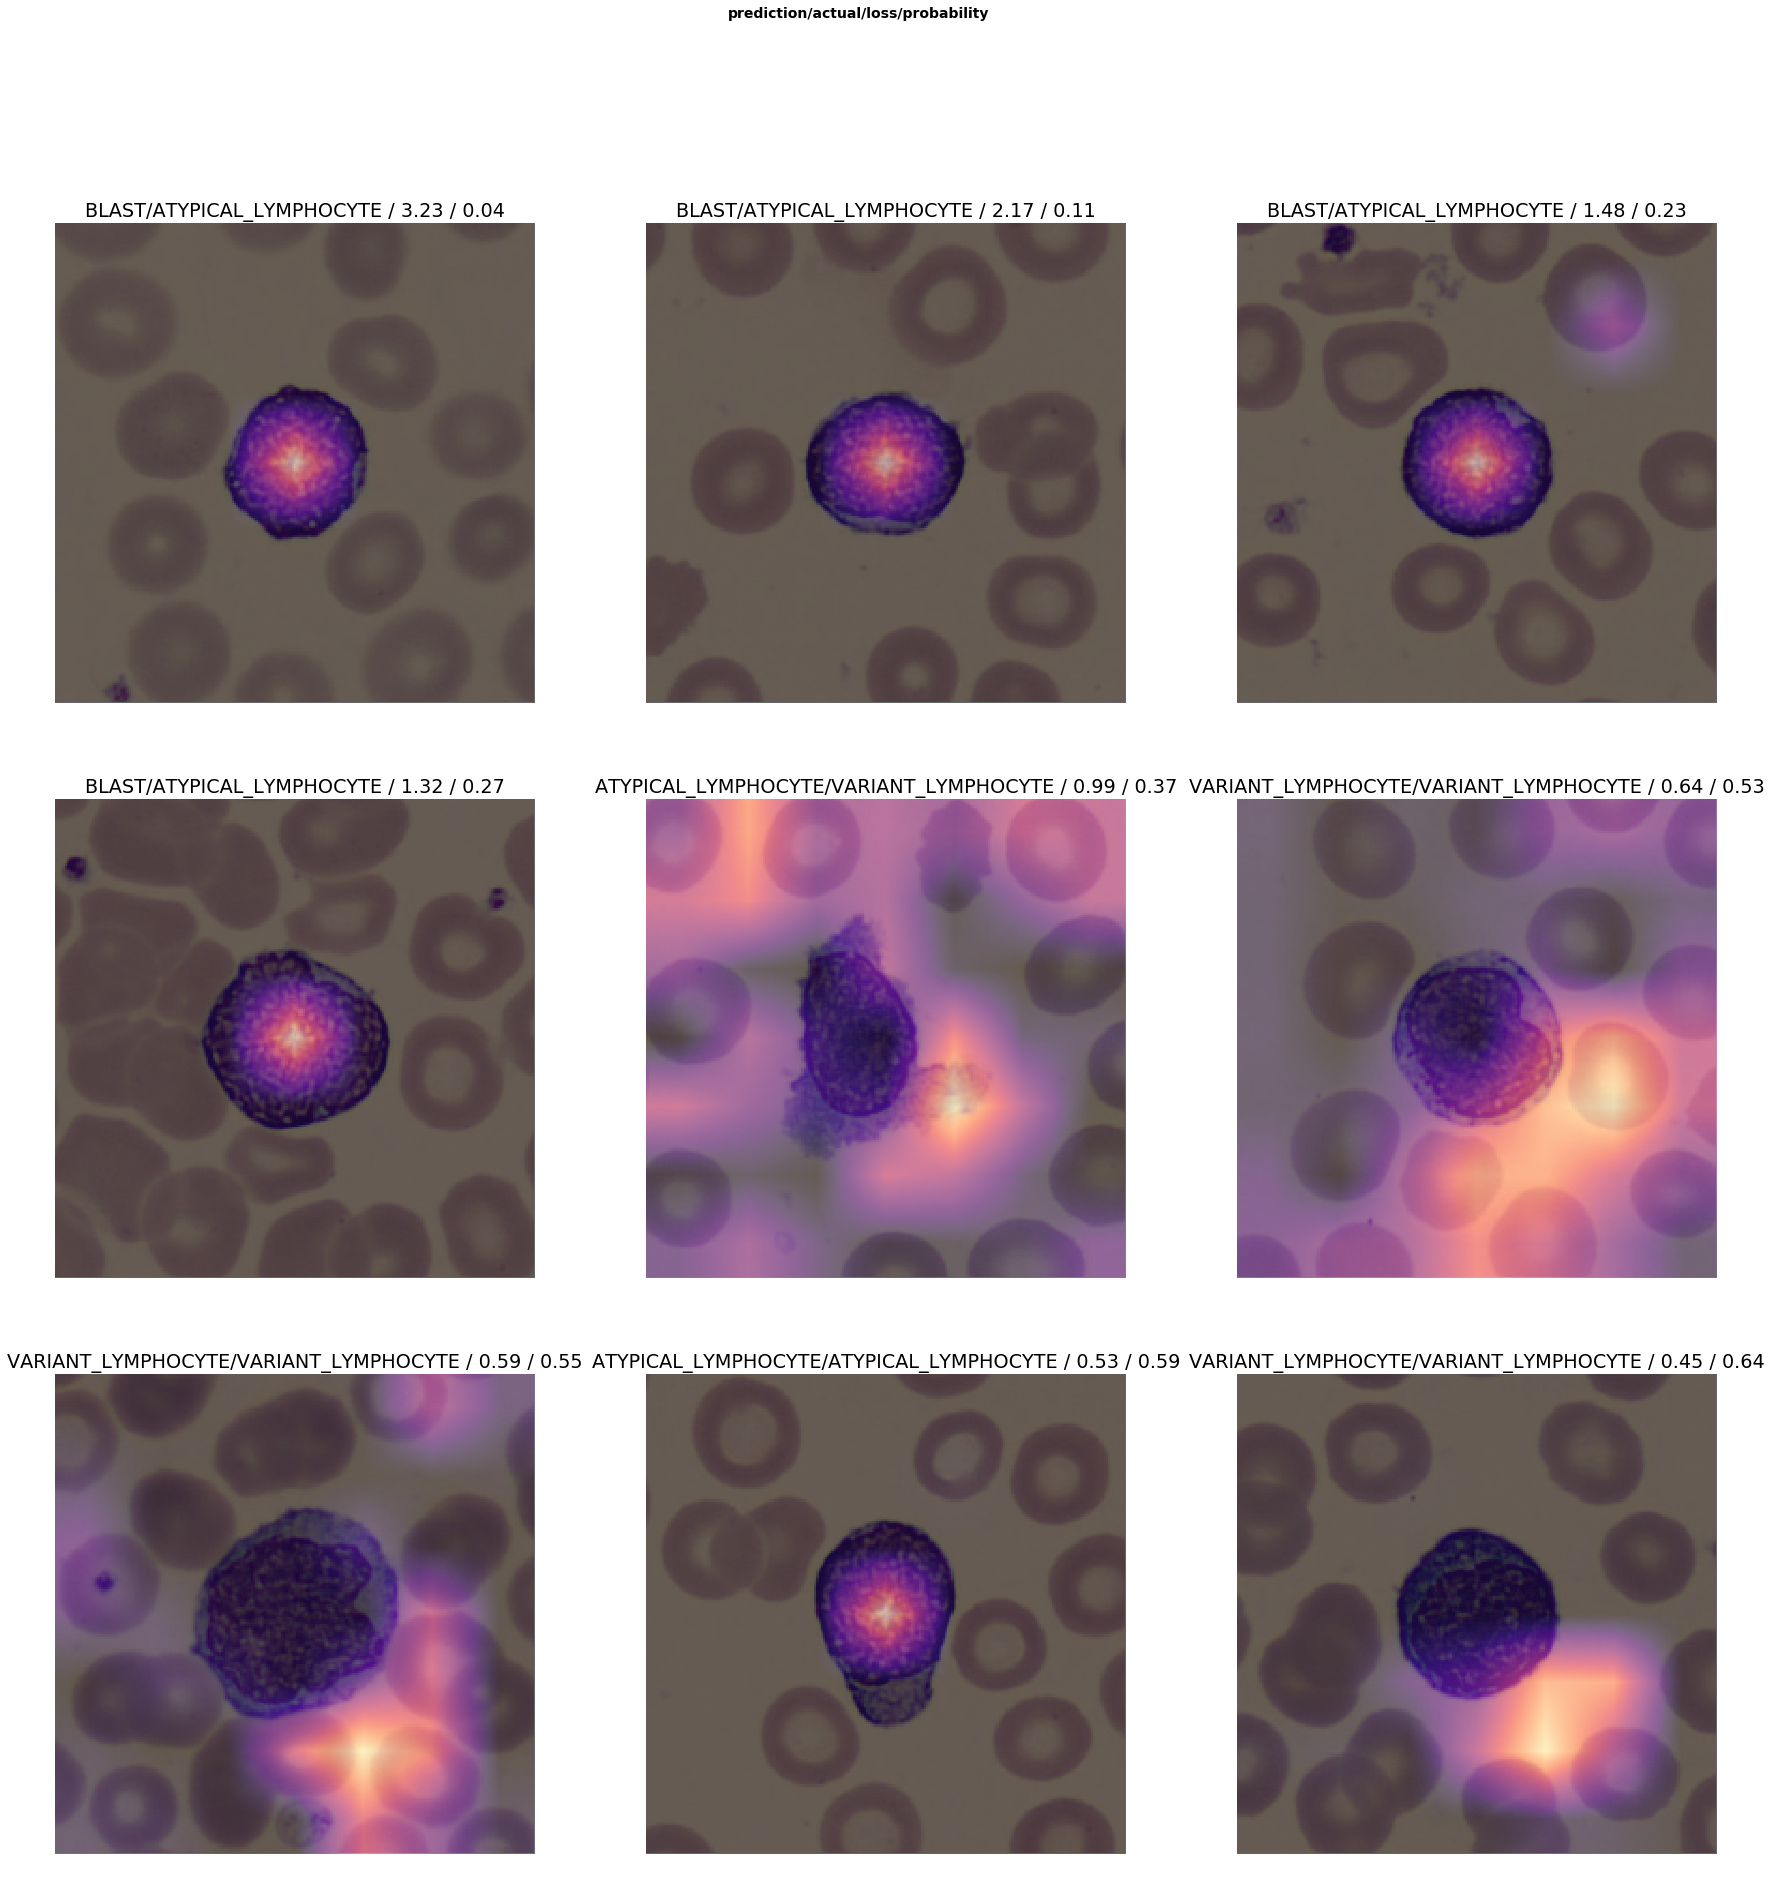

In [71]:
interp = ClassificationInterpretation.from_learner(learn_test)
losses,idxs = interp.top_losses()
interp.plot_top_losses(9, largest=True, figsize=(30,30), heatmap=True)

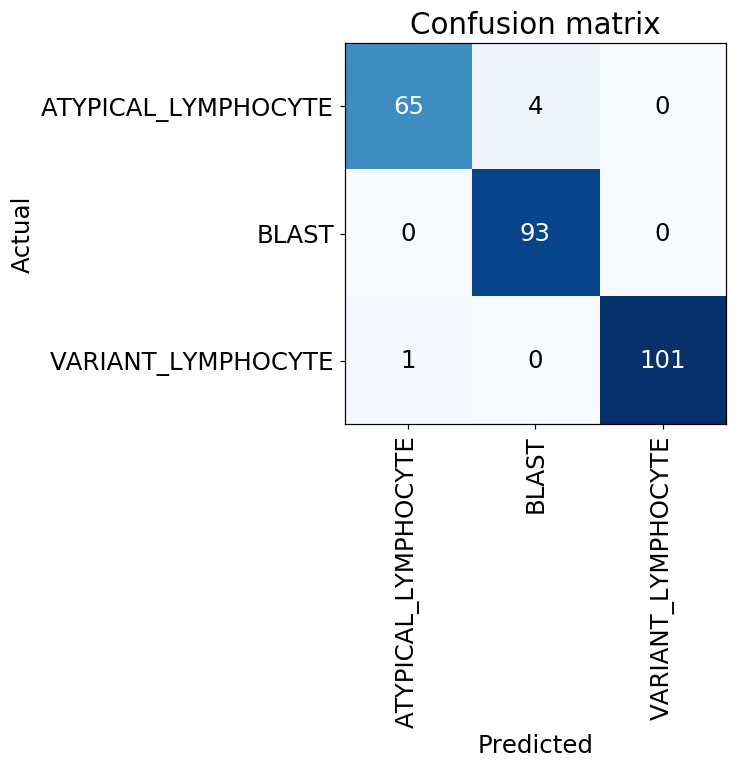

In [75]:
interp.plot_confusion_matrix(figsize=(7,7), dpi=110)



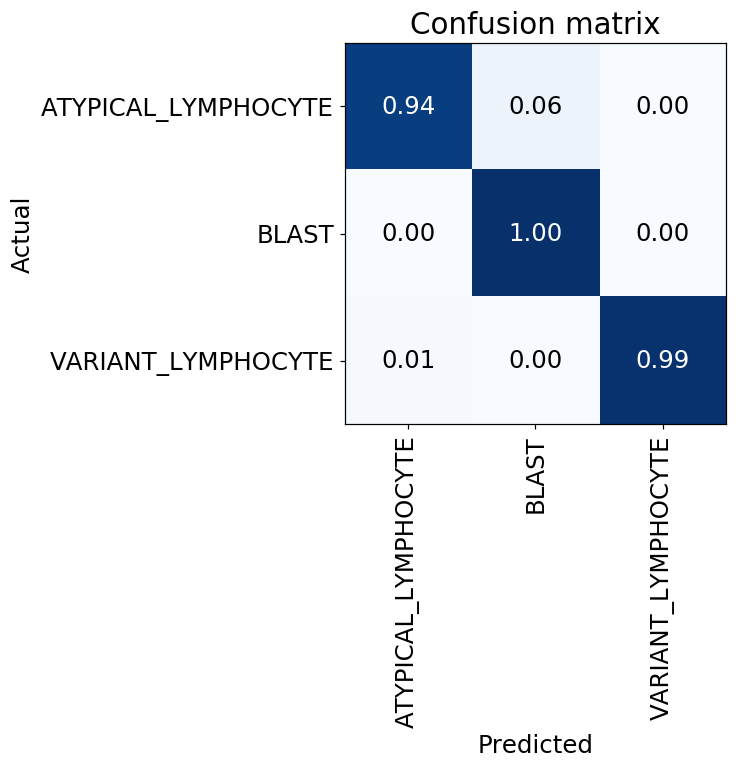

In [76]:
interp.plot_confusion_matrix(figsize=(7,7), dpi=110, normalize=True)



In [77]:
len(data_test.valid_ds)==len(losses)==len(idxs)

True